In [ ]:

import numpy as np
import pandas as pd
from   scipy.stats import gamma as gamma_dist
import matplotlib.pyplot as plt
import bayesflow as bf
import tensorflow as tf

# CONSTANTS
ALPHA      = 9                # Gamma shape (From Original Artical)
ETA_CONST  = 1e-3             # saliency noise – From Original Artical)
PATH       = "fixseqin_PB2expVP10.dat"   #data file

# 0)  LOAD FIXATIONS   
def load_fixations(path=PATH):
    cols = ['sentID','fixNum','onset','dur_ms','wordID',
            'x','y','line','flag1','flag2']
    return (
        pd.read_csv(path, sep=r'\s+', header=None, names=cols,
                    usecols=['sentID','wordID','dur_ms'])
          .query("dur_ms >= 50")          # remove microsaccades, For "cognative Fixations It is important"
          .reset_index(drop=True)
    )

df           = load_fixations()
sent_lens    = df.groupby("sentID")["wordID"].max().to_dict()   # {id: N_words}
all_sent_ids = np.array(list(sent_lens), dtype=int)
GLOBAL_PAD   = max(sent_lens.values())

# 1)  SIMULATOR  (9 raw channels, uses fixed η)
def gamma_timer(mu_T):
    """Draw a single fixation duration ∼ Gamma(α, scale=μ_T/α)."""
    return np.random.gamma(ALPHA, mu_T / ALPHA)

def swift_baseline(nu, r, mu_T, *, sent_ids, pad_len):  
    """
    Produce one batch of padded scan-paths with **fixed** η.
    Shapes of all channels: (B, T, 1)  — no extra dummy axes.
    """
    sent_ids = np.atleast_1d(sent_ids)          # (B,) even if B=1
    pad_len  = np.atleast_1d(pad_len)           # same
    B        = sent_ids.shape[0]
    T        = int(pad_len[0])
    zeros = lambda: np.zeros((B, T, 1), np.float32)

    fd, fw = zeros(), zeros()      # fix_dur, fix_word
    sl, sd = zeros(), zeros()      # sacc_len, sacc_dir
    le     = zeros()               # landing_error
    skp, rf= zeros(), zeros()      # skip_flag, refix_flag

    for b, sid in enumerate(sent_ids):
        N = sent_lens[int(sid)]
        for w in range(N):
            fd[b, w, 0] = gamma_timer(mu_T[b])
            fw[b, w, 0] = w + 1
            L           = np.random.poisson(r[b])
            sl[b, w, 0] = L
            sd[b, w, 0] = 1.0                      # always forward
            le[b, w, 0] = np.random.normal(0., 5. * ETA_CONST)

            p = 1 / (1 + np.exp(-20 * (nu[b] - 0.5)))
            skipped = np.random.rand() < p
            skp[b, w, 0] = skipped
            if not skipped:
                rf[b, w, 0] = np.random.rand() < p

    # sentence-level summary channels, copied along T
    skip_rate  = np.repeat(skp.mean(axis=1, keepdims=True), T, axis=1)
    refix_rate = np.repeat(rf .mean(axis=1, keepdims=True), T, axis=1)

    return dict(fix_dur=fd, fix_word=fw, sacc_len=sl, sacc_dir=sd,
                landing_error=le, skip_flag=skp, refix_flag=rf,
                skip_rate=skip_rate, refix_rate=refix_rate)

# 2)  PRIOR, META,  SIMULATOR WRAPPER
def sample_prior(batch_shape=None, **_):
    B = int(np.prod(batch_shape)) if batch_shape else 1
    return dict(
        nu   = np.random.uniform(0, 1 , B),
        r    = np.random.uniform(0 , 12 , B),
        mu_T = np.random.uniform(100, 400, B)
    )

def batch_meta(batch_shape):
    B    = int(batch_shape[0])
    sids = np.random.choice(all_sent_ids, size=B)
    return dict(sent_ids=sids.astype(np.int32),
                pad_len=np.full(B, GLOBAL_PAD, np.int32))

def simulator_fn(nu, r, mu_T, *, sent_ids, pad_len):
    """Wrapper that feeds fixed η to the baseline generator."""
    return swift_baseline(nu, r, mu_T,
                          sent_ids = sent_ids,
                          pad_len  = pad_len)

simulator = bf.make_simulator(
    [sample_prior, simulator_fn],  # building blocks
    {},                             # no object kwargs
    batch_meta
)

# 3)  NETWORKS  +  ADAPTER
inf_net = bf.networks.FlowMatching()
sum_net = bf.networks.SetTransformer(
    embed_dims =(64,), num_heads =(4,), mlp_depths=(2,), mlp_widths=(128,)
)

adapter = (
    bf.Adapter()
      .concatenate(["nu", "r", "mu_T"], into="inference_variables")

      # (B,1,T,1) → (B,T,1)
      .squeeze(
          ["fix_dur","fix_word","sacc_len","sacc_dir","landing_error",
           "skip_flag","refix_flag","skip_rate","refix_rate"],
          axis=1)

      #  9 channel → summary_variables  (B,T,9)
      .concatenate(
          ["fix_dur","fix_word","sacc_len","sacc_dir","landing_error",
           "skip_flag","refix_flag","skip_rate","refix_rate"],
          into="summary_variables")
)


# 4)  WORKFLOW
workflow = bf.BasicWorkflow(
    simulator        = simulator,
    adapter          = adapter,
    inference_network= inf_net,
    summary_network  = sum_net,
    inference_variables = ["nu", "r", "mu_T"],

)
print("Workflow initialised, ready to train.")

# For Debug check:   
raw_test = simulator.sample((4,))        
print("\nMini-batch channel shapes:")
for k, v in raw_test.items():
    print(f"{k:12s} {v.shape}")

# 5)  Training Part
history = workflow.fit_online(
    epochs                = 50,
    num_batches_per_epoch = 200,
    batch_size            = 64,
    validation_data       = 200,     # → every epoch: 200 fresh sims
    loss                  = "mmd",
    optimizer             = tf.keras.optimizers.Adam(1e-3),
    verbose               = 2
)


print("\nFirst 5 losses:", history.history["loss"][:5])


2025-08-14 22:23:09.263211: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-08-14 22:23:09.263233: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-14 22:23:09.263238: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1755199389.263568 7477302 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755199389.263762 7477302 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO:bayesflow:Using backend 'tensorflow'
INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


✅  Workflow initialised – ready to train.

Mini-batch channel shapes:
sent_ids     (4, 1)
pad_len      (4, 1)
nu           (4, 1)
r            (4, 1)
mu_T         (4, 1)
fix_dur      (4, 1, 59, 1)
fix_word     (4, 1, 59, 1)
sacc_len     (4, 1, 59, 1)
sacc_dir     (4, 1, 59, 1)
landing_error (4, 1, 59, 1)
skip_flag    (4, 1, 59, 1)
refix_flag   (4, 1, 59, 1)
skip_rate    (4, 1, 59, 1)
refix_rate   (4, 1, 59, 1)
Epoch 1/50


2025-08-14 22:23:11.334990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


200/200 - 32s - 162ms/step - loss: 3.0416 - val_loss: 1.0845
Epoch 2/50
200/200 - 26s - 131ms/step - loss: 1.0834 - val_loss: 1.0118
Epoch 3/50
200/200 - 27s - 134ms/step - loss: 0.7944 - val_loss: 0.7422
Epoch 4/50
200/200 - 25s - 126ms/step - loss: 0.6364 - val_loss: 0.6198
Epoch 5/50
200/200 - 24s - 119ms/step - loss: 0.5803 - val_loss: 0.4612
Epoch 6/50
200/200 - 23s - 116ms/step - loss: 0.5411 - val_loss: 0.4849
Epoch 7/50
200/200 - 24s - 120ms/step - loss: 0.4804 - val_loss: 0.5721
Epoch 8/50
200/200 - 26s - 129ms/step - loss: 0.4853 - val_loss: 0.4458
Epoch 9/50
200/200 - 25s - 125ms/step - loss: 0.4599 - val_loss: 0.4646
Epoch 10/50
200/200 - 25s - 127ms/step - loss: 0.4592 - val_loss: 0.4166
Epoch 11/50
200/200 - 25s - 124ms/step - loss: 0.4302 - val_loss: 0.4203
Epoch 12/50
200/200 - 26s - 128ms/step - loss: 0.4239 - val_loss: 0.3663
Epoch 13/50
200/200 - 25s - 125ms/step - loss: 0.4154 - val_loss: 0.3937
Epoch 14/50
200/200 - 24s - 122ms/step - loss: 0.4108 - val_loss: 0.376

losses
recovery
calibration_ecdf
z_score_contraction


/var/folders/vw/xhvswbfx4t357x7wwx_6v0cm0000gn/T/ipykernel_3726/269494101.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


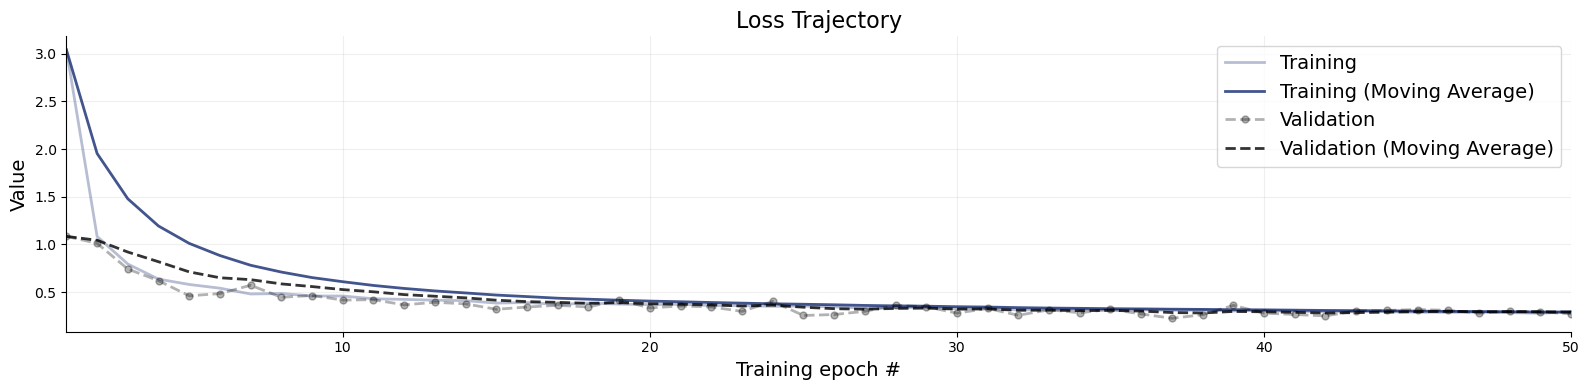

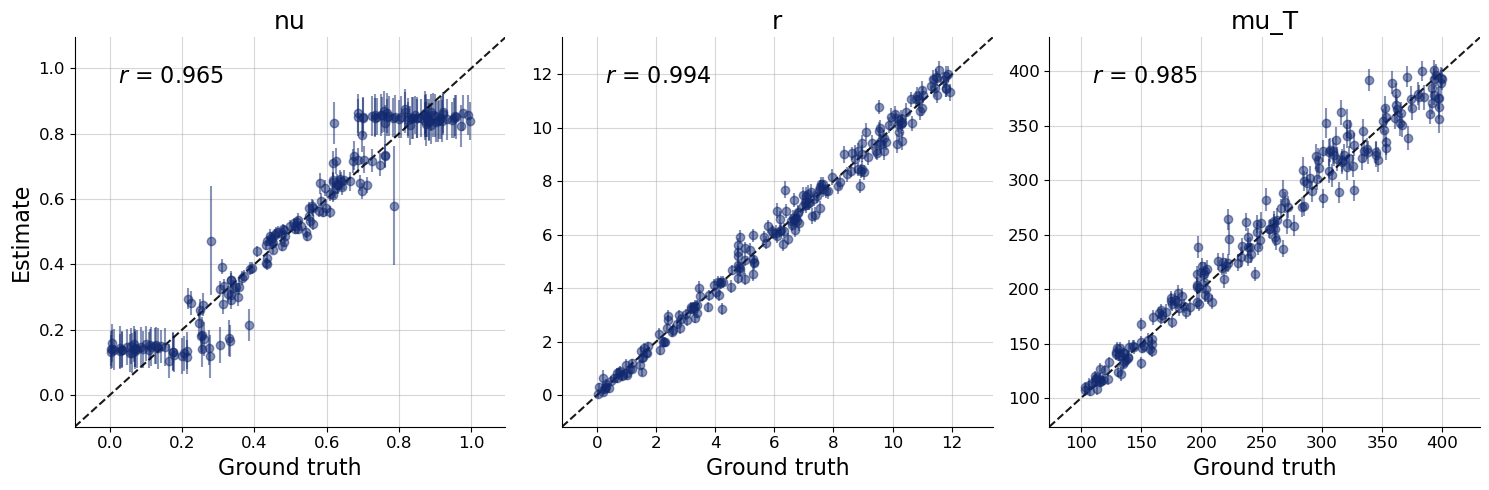

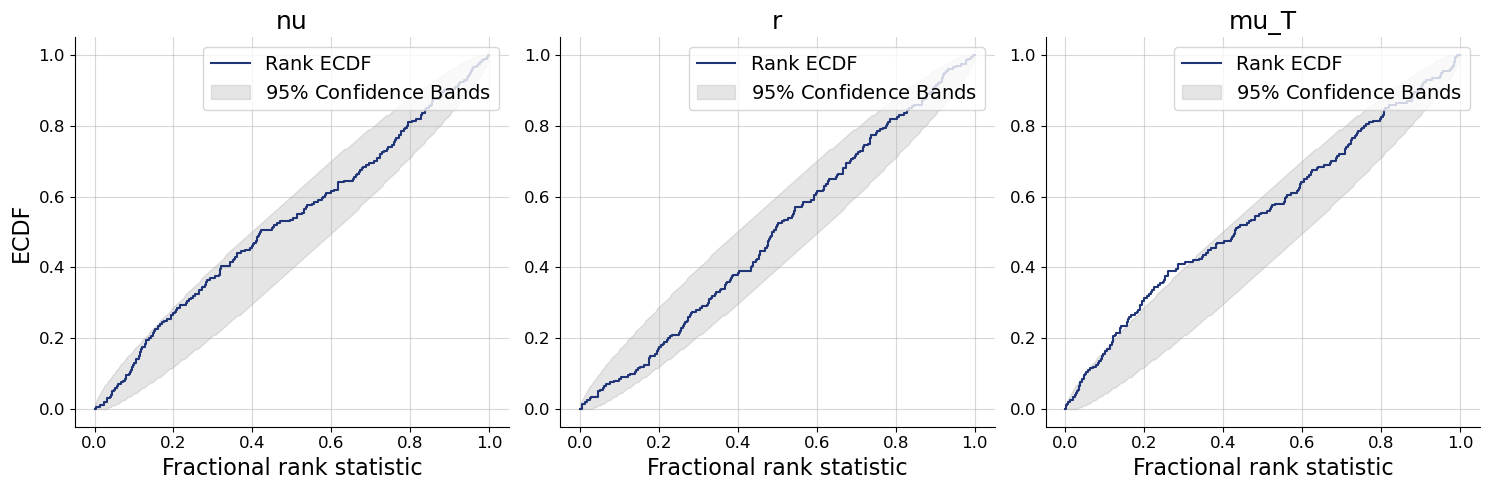

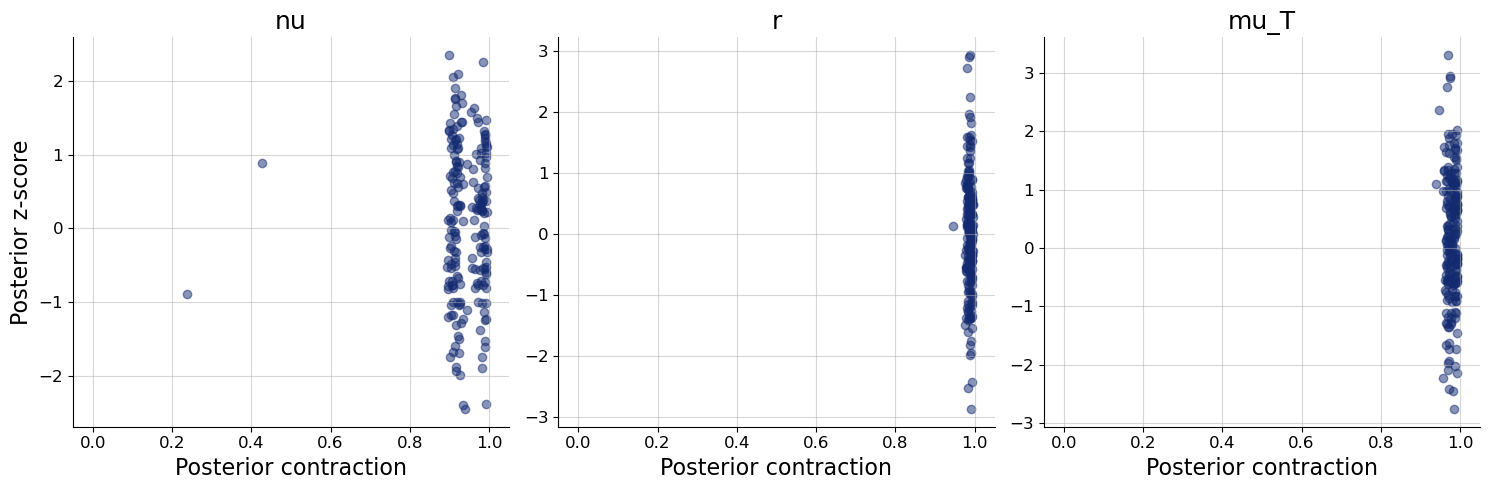

In [2]:
import bayesflow.diagnostics as bfd
import matplotlib.pyplot as plt
import numpy as np

S = 200                     
raw_test = workflow.simulate(batch_shape=(S,))   # simulator → raw dict
test_data = workflow.adapter(raw_test)           


M = 1000
posterior = workflow.sample(
    num_samples = M,
    conditions  = test_data      
)



figs = workflow.plot_default_diagnostics(
    test_data   = raw_test,   
    num_samples = M
)

for name, fig in figs.items():  
    print(name)
    fig.show()




Posterior means (reader-specific):
nu  : μ=  0.879  σ= 0.167
r   : μ=  1.562  σ= 0.814
mu_T: μ=123.002  σ=19.443


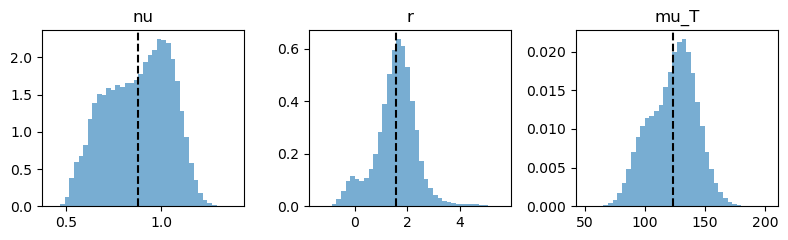

In [3]:
def pack_scans_to_raw(scans, pad_len):
    """
    Nine channels, each shape (B, 1, pad_len, 1)  ← cümle ekseni = 1
    """
    B, T = len(scans), pad_len
    zeros = lambda: np.zeros((B, 1, T, 1), np.float32)

    raw = dict(fix_dur=zeros(),  fix_word=zeros(),
               sacc_len=zeros(), sacc_dir=zeros(),
               landing_error=zeros(),
               skip_flag=zeros(), refix_flag=zeros(),
               skip_rate=zeros(),  refix_rate=zeros())

    for b, sc in enumerate(scans):
        n = len(sc["fix_dur"])
        raw["fix_dur"][b, 0, :n, 0]   = sc["fix_dur"]
        raw["fix_word"][b,0, :n, 0]   = sc["fix_word"]
        raw["sacc_len"][b,0, :n, 0]   = sc["sacc_len"]
        raw["sacc_dir"][b,0, :n, 0]   = np.sign(sc["sacc_len"])
        raw["skip_flag"][b,0,:n,0]    = sc["skip_flag"]
        raw["refix_flag"][b,0,:n,0]   = sc["refix_flag"]

        raw["skip_rate"][b,0,:,0]   = sc["skip_flag"].mean()
        raw["refix_rate"][b,0,:,0]  = sc["refix_flag"].mean()
    return raw

def build_scanpaths(df):
    scans=[]
    for sid,g in df.groupby('sentID',sort=True):
        g = g.sort_values('fixNum') if 'fixNum' in g else g.sort_index()
        w_ids = g.wordID.to_numpy()
        durs  = g.dur_ms.to_numpy(float)
        sacc  = np.diff(np.r_[w_ids[0], w_ids])
        skip  = (np.abs(sacc) > 1).astype(int)
        refix = np.r_[0,(w_ids[1:]==w_ids[:-1]).astype(int)]
        scans.append(dict(
            fix_word   = w_ids.astype(int),
            fix_dur    = durs,
            sacc_len   = sacc.astype(int),
            skip_flag  = skip,
            refix_flag = refix,
        ))
    return scans



# ---------------- REAL PARTICIPANT INFERENCE ------------------
df_real   = load_fixations(PATH)
DATA_REAL = build_scanpaths(df_real)

real_raw  = pack_scans_to_raw(DATA_REAL, GLOBAL_PAD)
# add dummy θ keys so that adapter finds them
real_raw["nu"]   = np.array([[0.]], np.float32)
real_raw["r"]    = np.array([[0.]], np.float32)
real_raw["mu_T"] = np.array([[0.]], np.float32)

cond      = workflow.adapter(real_raw, stage="predict")

posterior = workflow.sample(num_samples=1000, conditions=cond)

print("\nPosterior means (reader-specific):")
for p, v in posterior.items():
    print(f"{p:4s}: μ={v.mean():7.3f}  σ={v.std():6.3f}")

plt.figure(figsize=(8,2.5))
for i,(p,v) in enumerate(posterior.items(),1):
    plt.subplot(1,len(posterior),i)
    plt.hist(v.flatten(), 40, density=True, alpha=.6)
    plt.axvline(v.mean(), c='k', ls='--'); plt.title(p)
plt.tight_layout(); plt.show()


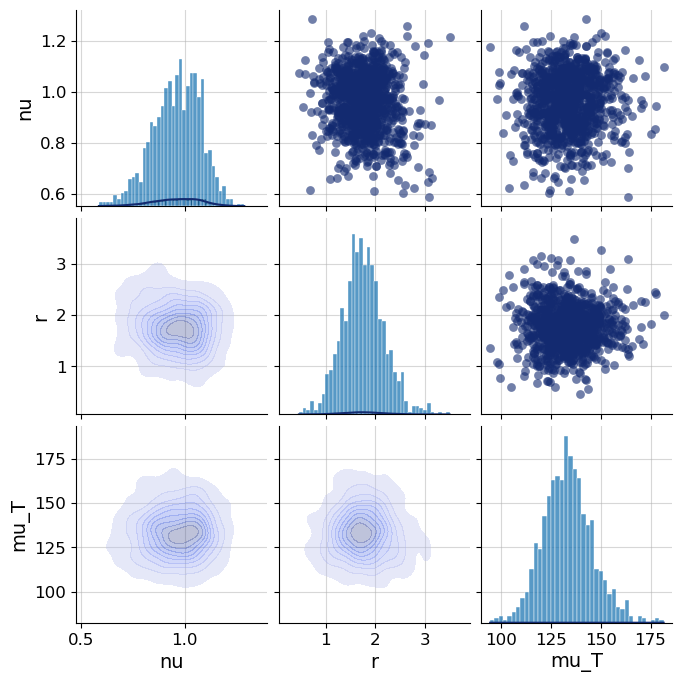

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose the first subject (index 0)
subject_idx = 0

# Extract and reshape to (num_samples, num_variables)
samples = np.column_stack([
    posterior["nu"][subject_idx].flatten(),
    posterior["r"][subject_idx].flatten(),
    posterior["mu_T"][subject_idx].flatten()
])

# Convert to dict as expected by BayesFlow
posterior_dict_single = {
    "nu": samples[:, 0][:, None],
    "r": samples[:, 1][:, None],
    "mu_T": samples[:, 2][:, None]
}

grid = bf.diagnostics.plots.pairs_posterior(
    estimates=posterior_dict_single,
    variable_keys=["nu", "r", "mu_T"],
    height=2.3,
    alpha=0.35
)

grid.map_diag(sns.histplot, bins=40, color="#1f77b4", edgecolor="w")
plt.show()


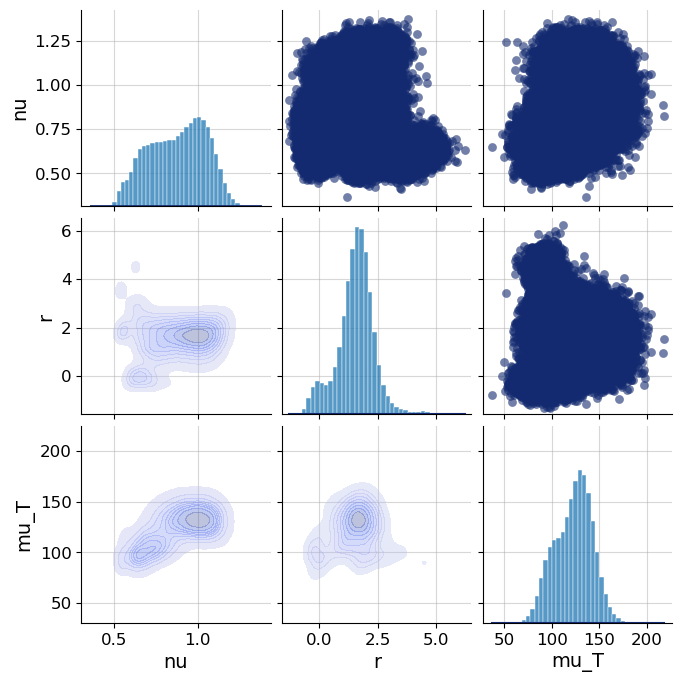

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import bayesflow as bf

# Posterior Examples take again
posterior = workflow.sample(num_samples=4000, conditions=cond)

# Convert BayesFlow's  pair plot function to good format for ploting
posterior_dict = {
    "nu": posterior["nu"].flatten()[:, None],
    "r": posterior["r"].flatten()[:, None],
    "mu_T": posterior["mu_T"].flatten()[:, None]
}



grid = bf.diagnostics.plots.pairs_posterior(
    estimates=posterior_dict,
    variable_keys=["nu", "r", "mu_T"],
    height=2.3,
    alpha=.35
)

# hist
grid.map_diag(
    sns.histplot, 
    bins=40, 
    color="#1f77b4", 
    edgecolor="w"
)

plt.show()


In [ ]:
# For Debug Check Posterior Values.


for k, v in posterior_dict.items():
    print(k, v.mean(), v.std(), v.min(), v.max())


nu 0.8789034 0.16725872 0.36488742 1.3749603
r 1.5622747 0.814267 -1.3081803 6.244174
mu_T 123.00348 19.42611 36.833023 218.0245
